# Named Entity Recognition using LSTMs

The purpose of this notebook is to train a model for Named Entity Recognition using a toy dataset available in the `data` folder.

Here are a few interesting posts:
* [Named-Entity evaluation metrics based on entity-level](https://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/)
* [Doing Named Entity Recognition? Don't optimize for F1](https://nlpers.blogspot.com/2006/08/doing-named-entity-recognition-dont.html)

In [1]:
# Load dependencies

import pandas as pd
import numpy as np
import json, os
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.cm as cm
color_1 = cm.get_cmap("Set2")(2) # set blue 
color_2 = cm.get_cmap("Set2")(1) # set orange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run src/tools.py
%run src/text_processing.py

## 1. Data loading

In [2]:
# Path to dataset

DATA_PATH = os.path.join('data', 'ner_dataset.json')
print('Data path: {}'.format(DATA_PATH))

Data path: data/ner_dataset.json


In [3]:
# Load the data

with open(DATA_PATH,'r') as f:
    content = f.read()
    f.close()
    
data = json.loads(content)

The dataset is structured as a dictionary. Let's check the keys of the dictionary.

In [4]:
# Show dictionary keys

data.keys()

dict_keys(['train', 'valid', 'test'])

In [5]:
# Store training/valid/test sets in separate lists

trainset = data['train']
validset = data['valid']
testset  = data['test']

print('There are {} samples in the training set.'.format(len(trainset)))
print('There are {} samples in the validation set.'.format(len(validset)))
print('There are {} samples in the test data.'.format(len(testset)))

There are 94 samples in the training set.
There are 21 samples in the validation set.
There are 23 samples in the test data.


## 2. Data exploration

Let's have a look at a few samples from the training data.

In [6]:
# Print a sample from the training set

for i in range(2,3):
    print('Sample {}:\n'.format(i))
    for j in range(len(trainset[i])):
        print(trainset[i][j])
    print('\n')

Sample 2:

[['Well', 'O'], ['repairs', 'O'], ['to', 'O'], ['lift', 'O'], ['Heidrun', 'B-LOC'], ['oil', 'O'], ['output', 'O'], ['-', 'O'], ['Statoil', 'B-ORG'], ['.', 'O']]
[['OSLO', 'B-LOC'], ['1996-08-22', 'O']]
[['Three', 'O'], ['plugged', 'O'], ['water', 'O'], ['injection', 'O'], ['wells', 'O'], ['on', 'O'], ['the', 'O'], ['Heidrun', 'B-LOC'], ['oilfield', 'O'], ['off', 'O'], ['mid-Norway', 'B-MISC'], ['will', 'O'], ['be', 'O'], ['reopened', 'O'], ['over', 'O'], ['the', 'O'], ['next', 'O'], ['month', 'O'], [',', 'O'], ['operator', 'O'], ['Den', 'B-ORG'], ['Norske', 'I-ORG'], ['Stats', 'I-ORG'], ['Oljeselskap', 'I-ORG'], ['AS', 'I-ORG'], ['(', 'O'], ['Statoil', 'B-ORG'], [')', 'O'], ['said', 'O'], ['on', 'O'], ['Thursday', 'O'], ['.', 'O']]
[['The', 'O'], ['plugged', 'O'], ['wells', 'O'], ['have', 'O'], ['accounted', 'O'], ['for', 'O'], ['a', 'O'], ['dip', 'O'], ['of', 'O'], ['30,000', 'O'], ['barrels', 'O'], ['per', 'O'], ['day', 'O'], ['(', 'O'], ['bpd', 'O'], [')', 'O'], ['in', 'O

Each sample has several sentences. Let's have a look at a single sentence from the training data. 

In [7]:
# Show a sentence from the training data

sample = trainset[0][0]

print("{:<11}{:<12}\n".format('Token','Named Entity Class'))

for pair in sample:
    print("{:<15}{:<12}".format(pair[0],pair[1]))

Token      Named Entity Class

CRICKET        O           
-              O           
GIBBS          B-PER       
GETS           O           
INTERNATIONAL  O           
CALL           O           
UP             O           
.              O           


Let's have a look at a sentence from the validation data. 

In [8]:
# Show a sentence from the validation data

sample = validset[0][2]

print("{:<11}{:<12}\n".format('Token','Named Entity Class'))

for pair in sample:
    print("{:<15}{:<12}".format(pair[0],pair[1]))

Token      Named Entity Class

A              O           
Moscow         B-LOC       
street         O           
vendor         O           
stabbed        O           
to             O           
death          O           
a              O           
woman          O           
judge          O           
in             O           
a              O           
city           O           
court          O           
on             O           
Friday         O           
after          O           
she            O           
fined          O           
him            O           
the            O           
equivalent     O           
of             O           
seven          O           
dollars        O           
for            O           
trading        O           
illegally      O           
,              O           
Interfax       B-ORG       
news           O           
agency         O           
said           O           
.              O           


and from the test data...

In [9]:
# Show a sentence from the test data

sample = testset[0][0]

print("{:<11}{:<12}\n".format('Token','Named Entity Class'))

for pair in sample:
    print("{:<15}{:<12}".format(pair[0],pair[1]))

Token      Named Entity Class

Sangetsu       B-ORG       
-              O           
96/97          O           
parent         O           
forecast       O           
.              O           


<font color=blue>__Observations__</font>

- Some tokens are capitalized, and others lowercased. During text processing, I will convert everything to lowercase.
- Each token comes with an assigned named entity class (e.g. `B-ORG`, `B-LOC`, etc.).

### What are the available named entity classes in the training set?

It would be useful at this point to know which named entity tags (classes) are available in the training set.

In [10]:
# Collect all NER classes from training data in a list

ner_tags = []

dataset = trainset

# Loop over samples
for i in range(len(dataset)):
    # Loop over sentences in a sample
    for j in range(len(dataset[i])):
        # Loop over (tok,tag) pairs in a sentence
        for k in range(len(dataset[i][j])):
            # Append NER class
            ner_tags.append(dataset[i][j][k][1])

# Return distinct NER tags
ner_classes = list(set(ner_tags))

print("There are {} available NER tags in the training set:\n\n{}n\n".format(len(ner_classes), ner_classes))

There are 9 available NER tags in the training set:

['B-PER', 'I-PER', 'B-ORG', 'I-LOC', 'I-MISC', 'O', 'I-ORG', 'B-LOC', 'B-MISC']n



<font color=blue>__Notes__</font>

* `O`    :  used for filler words 
* `PER`  :  persons
* `ORG`  :  organizations
* `LOC`  :  locations
* `MISC` :  miscellaneous

<font color=blue>__Observations__</font>

* The named entity tags define the number of classes in the target variable. These classes are mutually exclusive, i.e. a token can have exactly one class, and no more.
* Later, I will set up a neural network model to perform multi-class classification.

### What about class imbalance?

Below, I'm plotting the number of samples per class in the training set.

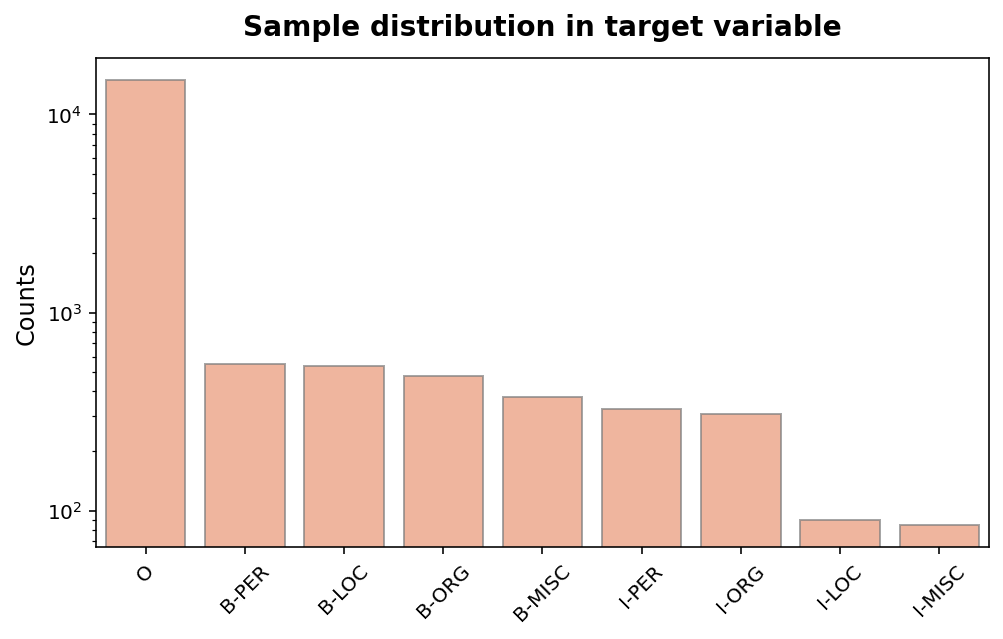

In [11]:
# Plot the distribution of samples in the target labels

target_sample_distribution(ner_tags)

In [12]:
pd.value_counts(ner_tags)

O         14952
B-PER       549
B-LOC       538
B-ORG       476
B-MISC      375
I-PER       325
I-ORG       307
I-LOC        90
I-MISC       85
dtype: int64

In [13]:
pd.value_counts(ner_tags, normalize=True).apply(lambda x:np.round(x,3))

O         0.845
B-PER     0.031
B-LOC     0.030
B-ORG     0.027
B-MISC    0.021
I-PER     0.018
I-ORG     0.017
I-LOC     0.005
I-MISC    0.005
dtype: float64

<font color=blue>__Observations__</font>

I can see that the dataset is imbalanced. 
* The most common named entity class is `O` (84.5% tokens).
* The least common named entity class is `I-MISC` (0.5% tokens).

Class imbalance can "prevent" a model from "learning" the minority classes reasonably well. Later, in section 5, I will use confusion matrices to represent the classifier's results. I will also use metrics, such as the *f1-score*, *precision*, and *recall*, better suited to imbalanced datasets (than the accuracy metric).

### How many tokens per sentence are there?

We saw already that each sample has several sentences of various sizes.

We represent text samples as sequences of tokens of the same length, when training sequence models. Therefore, it is helpful to know the (median) number of tokens per sample, as this can serve as a "guide" later when I have to pick a `sequence_length` for my sequences. 

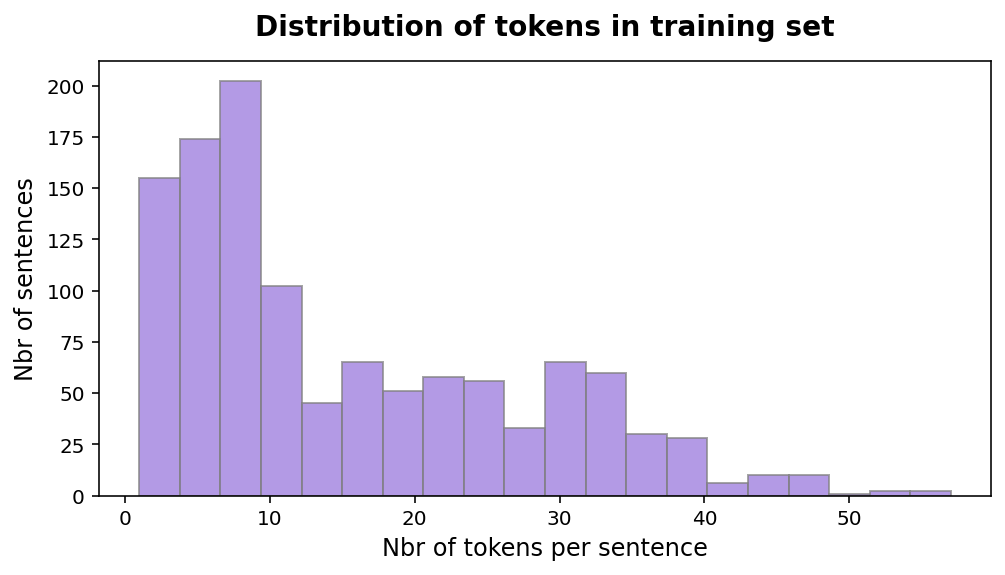

In [14]:
word_counts = plot_token_distribution(trainset,'training')

Below, I'm printing summary statistics of the number of tokens in sentences in the training data.

In [15]:
# Summary statistics for tokens in training data

pd.Series(word_counts).describe(percentiles=[0.50,0.75,0.80,0.90]).T

count    1155.000000
mean       15.322078
std        11.878654
min         1.000000
50%        11.000000
75%        24.000000
80%        28.000000
90%        33.000000
max        57.000000
dtype: float64

<font color=blue>__Training data__</font>

- The number of tokens in a sentence ranges between 1 (shortest sentence) and 57 (longest sentence).
- 75% of the sentences in the training data have 24 tokens (or less) (75-percentile).

### Total number of sentences

We've seen already that each sample has several sentences. Each of these sentences will be a "sample" for training, evaluating, or testing my model. Therefore, I would like to know how many sentences I have in total in the training, validation, and test sets.

In [16]:
print('\nTraining data: \t\t{} sentences'.format(sentence_distribution(trainset)))
print('Validation data: \t{} sentences'.format(sentence_distribution(validset)))
print('Test data: \t\t{} sentences\n'.format(sentence_distribution(testset)))


Training data: 		1155 sentences
Validation data: 	177 sentences
Test data: 		315 sentences



This confirms what we already know; the dataset is small (and imbalanced). So, I don't expect to obtain very good model performances. I should also pay attention to model complexity (i.e., avoid many layers and neurons) as the model can quickly start overfitting the training data.

## 3. Data preparation for sequence models

As I wrote above, when training sequence models, we represent text samples as sequences of tokens of the same length, preserving the word order. 

I wrote several functions to preprocess the text data; they are available in the `text_processing.py` module. In the following cells, I'm showing how each function is used to process the data.

Below, I'm showing how a text sample (and corresponding labels) looks before and after processing.

    Example 
    -------
    Sample:         ['cricket', '-', 'gibbs', 'gets', 'international', 'call', 'up', '.']
    Labels:         ['O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O']
    
    After processing
    ----------------
    Padded tensor:  [777, 11, 563, 1081, 176, 307, 34, 1, 4457, 4457, 4457, 4457, 4457, 4457, 4457]
    Padded labels:  [7, 7, 5, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9, 9, 9]   
        
<font color=blue>__Notes__</font>

- index for `__PAD__` token: 4457 (used for <PAD> token)
- index for `__UNK__` token: 4459 (used for out-of-vocabulary tokens)
- index for `__PAD__` label: 9 (used for the label corresponding to the <PAD> token)

### The build_vocabulary function

I use the `build_vocabulary` function to:
* compute word frequencies
* build a word2index dictionary from the training data to map tokens to a unique index.

In [17]:
# Build word frequencies and word2index dictionary from training data

word_freqs, word2index = build_vocabulary(dataset=trainset)

N = 50

# Show top N most frequent words in vocabulary and their frequency
print('Top {} most frequent tokens in training data:\n'.format(N))
print({k:word_freqs[k] for k in list(word_freqs)[0:N]})

# Show 
print('\nShow {} first (k,v) pairs from the word2index dictionary:\n'.format(N))
print({k:word2index[k] for k in list(word2index)[0:N]})


Vocabulary size: 4460

Top 50 most frequent tokens in training data:

{'the': 770, '.': 708, ',': 670, 'in': 338, 'of': 338, 'to': 323, 'a': 288, 'and': 232, 'on': 213, '"': 182, 'said': 170, '-': 154, "'s": 141, 'for': 119, '(': 118, ')': 118, 'at': 117, 'was': 104, 'that': 88, '1': 88, 'he': 79, 'with': 77, 'had': 66, 'it': 64, 'by': 64, 'his': 63, 'from': 63, '0': 59, 'is': 58, 'not': 54, 'be': 51, 'an': 49, 'has': 48, 'but': 48, 'up': 47, 'were': 47, ':': 47, 'as': 46, 'after': 46, 'she': 45, 'who': 44, '21': 41, '2': 41, 'her': 40, 'percent': 40, 'will': 39, 'first': 39, 'have': 38, 'been': 35, 'i': 34}

Show 50 first (k,v) pairs from the word2index dictionary:

{'the': 0, '.': 1, ',': 2, 'in': 3, 'of': 4, 'to': 5, 'a': 6, 'and': 7, 'on': 8, '"': 9, 'said': 10, '-': 11, "'s": 12, 'for': 13, '(': 14, ')': 15, 'at': 16, 'was': 17, 'that': 18, '1': 19, 'he': 20, 'with': 21, 'had': 22, 'it': 23, 'by': 24, 'his': 25, 'from': 26, '0': 27, 'is': 28, 'not': 29, 'be': 30, 'an': 31, 'has': 

In [18]:
# Show index for '__PAD__' token (used for padding)
word2index['__PAD__']

4457

In [19]:
# Show index for '__UNK__' token (used for OOV words)
word2index['__UNK__']

4459

Next, I use the `word2index` dictionary to create sequences of tokens from samples of text; each token is assigned to its unique integer index. 

### The tag2index dictionary

I also need to assign a unique integer to each named entity class (tag).

The `tag2index` dictionary maps named entity tags to unique integers.

In [20]:
# Map target labels to integers

labels_int = range(len(ner_classes))
tag2index  = dict(zip(ner_classes, labels_int))

# Show tag2index dict
tag2index

{'B-PER': 0,
 'I-PER': 1,
 'B-ORG': 2,
 'I-LOC': 3,
 'I-MISC': 4,
 'O': 5,
 'I-ORG': 6,
 'B-LOC': 7,
 'B-MISC': 8}

### The pad_sentences function

The `pad_sentences` function takes a (single) sequence of tokens (and sequence of labels) and performs the following steps:

- maps tokens to vocabulary indexes
- maps named entity tags to class indexes
- pads token and label sequences according to a specified `sequence_length`.

Let's see this with an example.

In [21]:
sample = validset[3][0]

sent_tensor, label_tensor = pad_sentences(sample, word2index,
                                          tag2index, seq_len=15, verbose=False)

print('Example:')
print('--------\n')
print('Sample: \t{}\n'.format([tok[0].lower() for tok in sample]))
print('Padded tensor:  {}'.format(sent_tensor))
print('Padded labels:  {}\n'.format(label_tensor))

Example:
--------

Sample: 	['rwandan', 'refugee', 'group', 'calls', 'for', 'calm', 'over', 'census', '.']

Padded tensor:  [438, 4459, 328, 3772, 13, 4459, 96, 4459, 1, 4457, 4457, 4457, 4457, 4457, 4457]
Padded labels:  [8, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9]



### The prep_data function

Finaly, the `prep_data` function applies the `pad_sentences` function to all samples of a provided dataset.

In [22]:
# Choose sequence length for padding

sequence_length = 50

In [23]:
# Process training sequences (tokens and labels)

X_tr, y_tr = prep_data(dataset=trainset, seq_len = sequence_length, vocab = word2index, tag_map = tag2index)

print('Number of sequences in training data: {}, {}'.format(len(X_tr),len(y_tr)))

Number of sequences in training data: 1155, 1155


In [24]:
# Process validation sequences (tokens and labels)

X_val, y_val = prep_data(dataset=validset, seq_len = sequence_length, vocab = word2index, tag_map = tag2index)

print('Number of sequences in validation data: {}, {}'.format(len(X_val),len(y_val)))

Number of sequences in validation data: 177, 177


In [25]:
# Process test sequences (tokens and labels)

X_te, y_te = prep_data(dataset=testset, seq_len = sequence_length, vocab = word2index, tag_map = tag2index)

print('Number of sequences in test data: {}, {}'.format(len(X_te),len(y_te)))

Number of sequences in test data: 315, 315


Below, I'm doing some sanity checks, to make sure that the text processing worked as expected.

In [26]:
# Training sequences (tokens)
X_tr

array([[ 777,   11,  563, ..., 4457, 4457, 4457],
       [1855,   90, 4457, ..., 4457, 4457, 4457],
       [  91,  260, 1856, ..., 4457, 4457, 4457],
       ...,
       [ 174,  105,   75, ..., 4457, 4457, 4457],
       [ 105,  115,  119, ..., 4457, 4457, 4457],
       [  14,  295,   15, ..., 4457, 4457, 4457]])

In [27]:
# Training sequences (labels)
y_tr

array([[5, 5, 0, ..., 9, 9, 9],
       [7, 5, 9, ..., 9, 9, 9],
       [2, 6, 5, ..., 9, 9, 9],
       ...,
       [5, 5, 5, ..., 9, 9, 9],
       [5, 5, 5, ..., 9, 9, 9],
       [5, 7, 5, ..., 9, 9, 9]])

In [28]:
# Print sequence length for the first sample in training data
len(X_tr[0])

50

In [29]:
# Print token sequence for the first sample in training data

print(X_tr[0])

[ 777   11  563 1081  176  307   34    1 4457 4457 4457 4457 4457 4457
 4457 4457 4457 4457 4457 4457 4457 4457 4457 4457 4457 4457 4457 4457
 4457 4457 4457 4457 4457 4457 4457 4457 4457 4457 4457 4457 4457 4457
 4457 4457 4457 4457 4457 4457 4457 4457]


In [30]:
# Print label sequence for the first sample in training data

y_tr[0]

array([5, 5, 0, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9])

## 4. Building an NER model using LSTM neural networks

In [31]:
# Load dependencies

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM

from tensorflow.keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss',patience=6)]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

### Train the NER model

I will now create a neural network model with an LSTM layer to perform multi-class classification. For the classifier, I will use a `Dense` output layer, a `softmax` activation function and set the number of neurons in the output layer equal to the number of classes. For the loss function, I will use `sparse_categorical_crossentropy` because the targets are integers. Finally, the `Embedding` layer is used to transform the representations of the text samples into an optimal one for this task.

In [32]:
# Set netword parameters

input_dim    = len(word2index)      # Size of the vocabulary
output_dim   = 300                  # Embedding size
input_length = sequence_length      # Sequence length

batch_size   = 64
epochs       = 500

num_classes = len(tag2index) + 1    # Adding 1 for the <PAD> label (9)
print('Total number of classes: ',num_classes)

Total number of classes:  10


### Hyper-parameter tuning

Below, I will fine-tune some hyperparameters of my model using grid-search with cross-validation. The `KerasClassifier` is a wrapper that allows to use Keras models with scikit-learn objects.

In [33]:
# Create sequential model for multi-class classification

def build_ner_model(output_dim = 64, dropout = 0.2, learning_rate = 0.001):                                   
    
    model = Sequential()
    
    model.add(Embedding(input_dim = input_dim, 
                        output_dim = output_dim, 
                        input_length = input_length))
    
    model.add(LSTM(units=output_dim, 
                   return_sequences=True, 
                   dropout=dropout, 
                   recurrent_dropout=dropout))
    
    model.add(Dense(num_classes, activation="softmax"))

    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', 
                  #optimizer='adam',
                  optimizer = optimizer,
                  metrics=['accuracy'])
    #model.summary()

    return model

# Create keras wrapper
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_ner_model)

In [37]:
# Define hyper-parameters to tune

params = {'dropout':      [0.2, 0.3, 0.4],   # Tune dropout rate
          'output_dim' :  [128, 256, 512],   # Tune embedding size
          'learning_rate': [1e-4,1e-3,1e-2]  # Tune learning rate
         
         }


In [38]:
%%time

grid_cv = GridSearchCV(keras_class, 
                       params, 
                       cv=3,
                       return_train_score=True,
                      )

grid_result = grid_cv.fit(X_tr, y_tr,                      # cv uses only training data
                          epochs=epochs, 
                          validation_data=(X_val, y_val),  # val data is used only for EarlyStopping
                          callbacks=[callbacks],
                          verbose=0)
# Wall time: 4h 16min 53s

25/25 [==============================] - 2s 92ms/step - loss: 0.0031 - accuracy: 0.9991
CPU times: user 17h 17min 12s, sys: 8h 47min 42s, total: 1d 2h 4min 55s
Wall time: 4h 16min 53s


In [40]:
# Best model

model = grid_cv.best_estimator_.model

In [44]:
# Collect gs results

df_results = pd.DataFrame(grid_result.cv_results_)[['param_output_dim','param_dropout', 'param_learning_rate',
                                                    'mean_train_score', 'std_train_score', 
                                                    'mean_test_score', 'std_test_score']]

# Sort gs results by performance on the validation folds
df_results.sort_values(by='mean_test_score', ascending=False).head(10)

,param_output_dim,param_dropout,param_learning_rate,mean_train_score,std_train_score,mean_test_score,std_test_score
24,128,0.4,0.01,0.998788,0.000178,0.964121,0.004073
8,512,0.2,0.01,0.998814,0.000251,0.963325,0.003546
26,512,0.4,0.01,0.998823,0.000398,0.963255,0.005100
6,128,0.2,0.01,0.998641,0.000032,0.963048,0.002782
7,256,0.2,0.01,0.998848,0.000293,0.962823,0.004947
25,256,0.4,0.01,0.998874,0.000333,0.962667,0.003593
17,512,0.3,0.01,0.998493,0.000326,0.962009,0.002990
16,256,0.3,0.01,0.998797,0.000382,0.961853,0.001606
15,128,0.3,0.01,0.998632,0.000297,0.960398,0.002151
5,512,0.2,0.001,0.995446,0.002193,0.960000,0.005460


In [45]:
# Show best hyperparameter values

grid_cv.best_params_

{'dropout': 0.4, 'learning_rate': 0.01, 'output_dim': 128}

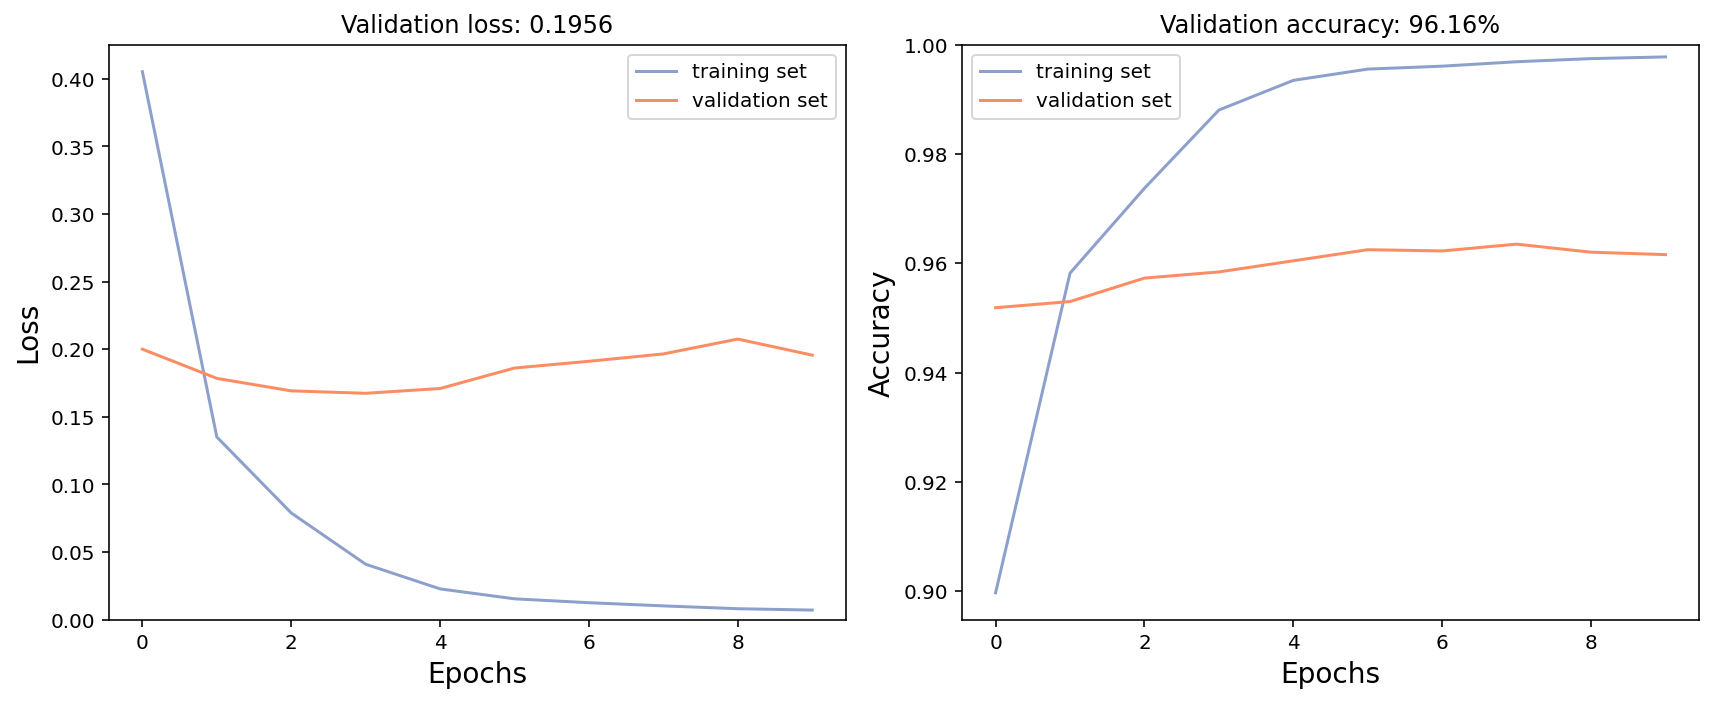

In [46]:
# Plot accuracy/loss curves for best model

plot_loss_accuracy_curves(model.history)

<font color=blue>__Observations__</font>

The "best" model has achieved an accuracy of ~96% on the validation data. We should take this result with a grain of salt! 
* We saw that the dataset is imbalanced. The accuracy metric can be "misleading" in imbalanced datasets. We want to use other metrics such as the f1-score, precision and recall with imbalanced datasets (see Section 5 below). Moreover, the majority class is the `O` named entity tag, assigned to filler tokens. In the following section, I will compute the accuracy and the other metrics I mentioned above, without the `O` class.
* Moreover, the accuracy is computed without removing the `<PAD>` tokens. It is preferred to remove the predictions for `<PAD>` tokens before computing model performance (see next section).

## 5. Testing

### Compute predictions

As we see below, the model's predictions have 3 "axes":

* the number of samples
* the number of tokens in each sample (padded to be as long as the longest sentence in the batch)
* the number of possible targets labels (the 10 named entity tags)

In [47]:
# Show the 3 axes available in predictions

model.predict(X_tr).shape

(1155, 50, 10)

In [48]:
# Compute predictions

y_tr_pred    = np.argmax(model.predict(X_tr),  axis=2) 
y_val_pred   = np.argmax(model.predict(X_val), axis=2)
y_te_pred    = np.argmax(model.predict(X_te),  axis=2)

In [49]:
print('Training output:\t',y_tr_pred.shape)
print('Validation output:\t',y_val_pred.shape)
print('Test output:\t\t',y_te_pred.shape)

Training output:	 (1155, 50)
Validation output:	 (177, 50)
Test output:		 (315, 50)


### Show predictions for one sample

In [51]:
# Test sample
idx = 1
sample = testset[0][idx]
print('Tokens: {}\n'.format([pair[0] for pair in sample]))

mask = (y_te[idx] !=9)
print('True labels: \t\t{}'.format(y_te[idx][mask]))
print('Predicted labels: \t{}'.format(y_te_pred[idx][mask]))


Tokens: ['TOKYO', '1996-12-06']

True labels: 		[7 5]
Predicted labels: 	[7 3]


In [52]:
# Validation sample

idx = 0
sample = validset[0][idx]
print('Tokens: {}\n'.format([pair[0] for pair in sample]))

mask = (y_val[idx] !=9)
print('True labels: \t\t{}'.format(y_val[idx][mask]))
print('Predicted labels: \t{}'.format(y_val_pred[idx][mask]))

Tokens: ['Russian', 'judge', 'stabbed', 'to', 'death', 'over', '$', '7', 'fine', '.']

True labels: 		[8 5 5 5 5 5 5 5 5 5]
Predicted labels: 	[8 5 5 5 5 5 5 5 5 5]


### Performance per label type per token

Below, I compute the model performance per label type and per token using the accuracy and classification reports.

I used two approaches:
- using a mask to avoid counting the `<PAD>` tokens
- using a mask to avoid counting the `<PAD>` and `O` tokens

#### Accuracy

In [53]:
# 1st approach: avoid counting <PAD> tokens

def compute_accuracy_without_padding(y,y_pred):
    
    '''
    This function computes the accuracy of a NER model.
    It creates a mask to avoid counting the <PAD> tokens.
    
    Inputs:
    - y      :   np.array(), true labels with 3 axes (samples, seq_length, num_classes)
    - y_pred :   np.array(), predicted labels with 3 axes (samples, seq_length, num_classes)
    
    Output:
    - accuracy : float, model accuracy without counting the <PAD> token.
    '''
    
    y      = y.flatten()       # Labels
    y_pred = y_pred.flatten()  # Predictions

    # Remove the labels corresponding to <PAD> token
    mask = y != 9            # Class index for <PAD> token: 9

    accuracy = np.sum(y[mask] == y_pred[mask])/float(np.sum(mask))
    return 100*np.round(accuracy,2)
   
print('Model accuracy (without <PAD> tokens)\n')
print(38*'=','\n')
print('Accuracy on training data: \t{}%'.format(compute_accuracy_without_padding(y_tr,y_tr_pred)))
print('Accuracy on validation data: \t{}%'.format(compute_accuracy_without_padding(y_val,y_val_pred)))
print('Accuracy on test data: \t\t{}%'.format(compute_accuracy_without_padding(y_te,y_te_pred)))

Model accuracy (without <PAD> tokens)


Accuracy on training data: 	100.0%
Accuracy on validation data: 	90.0%
Accuracy on test data: 		86.0%


In [54]:
# 2nd approach: avoid counting <PAD> and `O` tokens.

def compute_accuracy_without_PAD_O(y,y_pred,tag_dict = tag2index):
    
    '''
    This function computes the accuracy of a NER model.
    It creates a mask to avoid counting the <PAD> and `O` tokens.
    
    Inputs:
    - y      :   np.array(), true labels with 3 axes (samples, seq_length, num_classes)
    - y_pred :   np.array(), predicted labels with 3 axes (samples, seq_length, num_classes)
    
    Output:
    - accuracy : float, model accuracy without counting the <PAD> and `O` tokens
    '''
    
    y      = y.flatten()       # Labels
    y_pred = y_pred.flatten()  # Predictions

    # Remove labels corresponding to <PAD> and `O` tokens
    mask = (y != 9) & (y != tag_dict['O'])      # Class index for <PAD> token: 9

    accuracy = np.sum(y[mask] == y_pred[mask])/float(np.sum(mask))
    return 100*np.round(accuracy,2)

In [55]:
# Print model accuracy without counting <PAD> and `O` tokens
print("Model accuracy (without <PAD> and 'O's tokens)\n")
print(46*'=','\n')

print('Accuracy on training data: \t{}%'.format(compute_accuracy_without_PAD_O(y_tr,y_tr_pred)))
print('Accuracy on validation data: \t{}%'.format(compute_accuracy_without_PAD_O(y_val,y_val_pred)))
print('Accuracy on test data: \t\t{}%'.format(compute_accuracy_without_PAD_O(y_te,y_te_pred)))

Model accuracy (without <PAD> and 'O's tokens)


Accuracy on training data: 	98.0%
Accuracy on validation data: 	36.0%
Accuracy on test data: 		27.0%


As expected, the accuracy of the model on the validation and test data is much worse once we remove the <PAD> and the <O> tokens. The <O> token is assigned to filler words and corresponds to the majority class in the data.
    
#### Classification reports
    
Below, I will present the classification report, computed without counting the <PAD> and `O` tokens.

In [56]:
def compute_metrics_without_PAD_O(y,y_pred, tag_dict = tag2index):
    
    '''
    This function returns the classification report for a trained NER model.
    It creates a mask to avoid counting the <PAD> and `O` tokens.
    
    Inputs:
    - y      :   np.array(), true labels with 3 axes (samples, seq_length, num_classes)
    - y_pred :   np.array(), predicted labels with 3 axes (samples, seq_length, num_classes)
    
    Output:
    - accuracy : float, model accuracy without counting the <PAD> and `O` tokens
    '''

    y      = y.flatten()       # Labels
    y_pred = y_pred.flatten()  # Predictions

    # Remove labels corresponding to <PAD> and `O` tokens
    mask = (y != 9) & (y != tag_dict['O'])          # Class index for <PAD> token: 9

    cm = classification_report(y[mask],y_pred[mask], digits=3, zero_division=1,
                               labels=[*range(0,len(tag_dict)+1)], target_names=list(tag_dict.keys())+['<PAD>']
                              )
    print(cm)

In [57]:
# Show classification report for validation data

compute_metrics_without_PAD_O(y_val,y_val_pred)

              precision    recall  f1-score   support

       B-PER      0.893     0.278     0.424        90
       I-PER      0.875     0.241     0.378        58
       B-ORG      0.625     0.100     0.172        50
       I-LOC      0.667     0.200     0.308        10
      I-MISC      0.600     0.214     0.316        14
           O      0.000     1.000     0.000         0
       I-ORG      0.400     0.108     0.170        37
       B-LOC      0.895     0.667     0.764       102
      B-MISC      0.757     0.509     0.609        55
       <PAD>      0.000     1.000     0.000         0

    accuracy                          0.358       416
   macro avg      0.571     0.432     0.314       416
weighted avg      0.782     0.358     0.466       416



In [58]:
# Show classification report for test data

compute_metrics_without_PAD_O(y_te,y_te_pred)

              precision    recall  f1-score   support

       B-PER      0.895     0.195     0.321        87
       I-PER      1.000     0.273     0.429        55
       B-ORG      0.875     0.096     0.173       219
       I-LOC      0.600     0.321     0.419        28
      I-MISC      0.750     0.222     0.343        27
           O      0.000     1.000     0.000         0
       I-ORG      0.909     0.147     0.253        68
       B-LOC      0.720     0.636     0.675       121
      B-MISC      0.625     0.490     0.549        51
       <PAD>      1.000     1.000     1.000         0

   micro avg      0.274     0.274     0.274       656
   macro avg      0.737     0.438     0.416       656
weighted avg      0.827     0.274     0.362       656



#### Confusion matrices

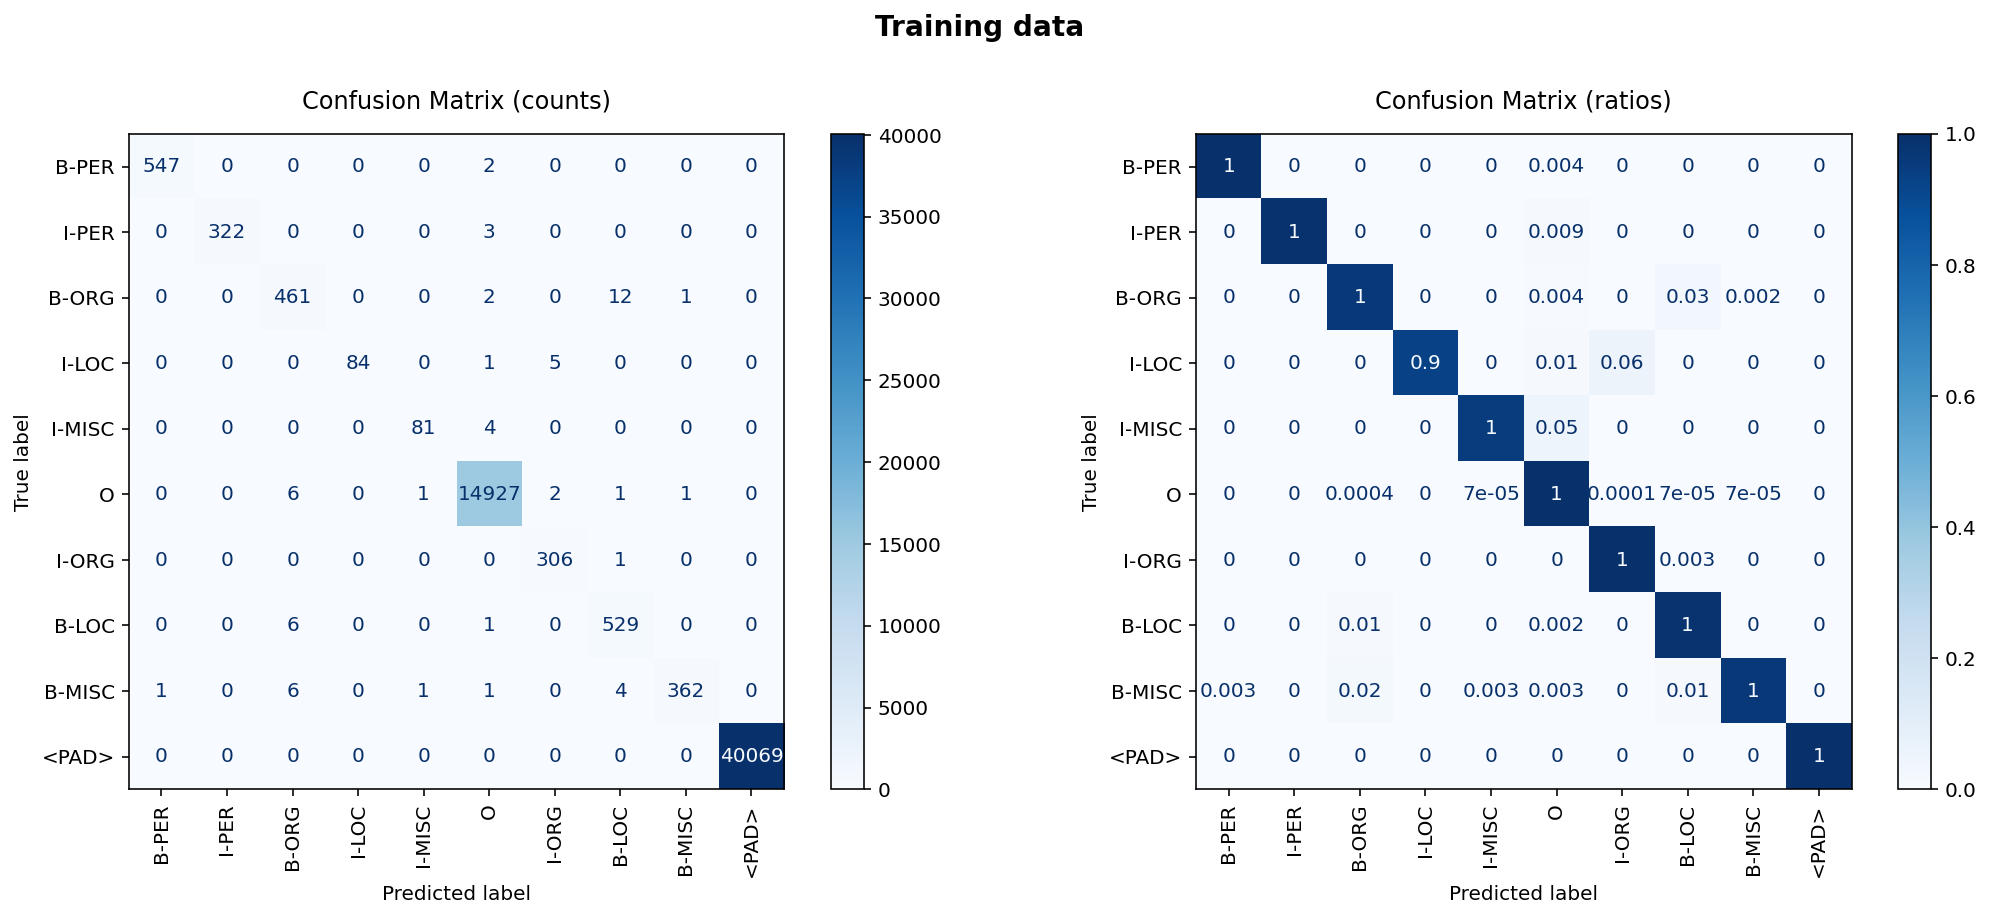

In [59]:
# Training data

display_labels = list(tag2index.keys()) + ['<PAD>']
plot_confusion_matrix(y_tr.flatten(),y_tr_pred.flatten(),display_labels,'Training data')

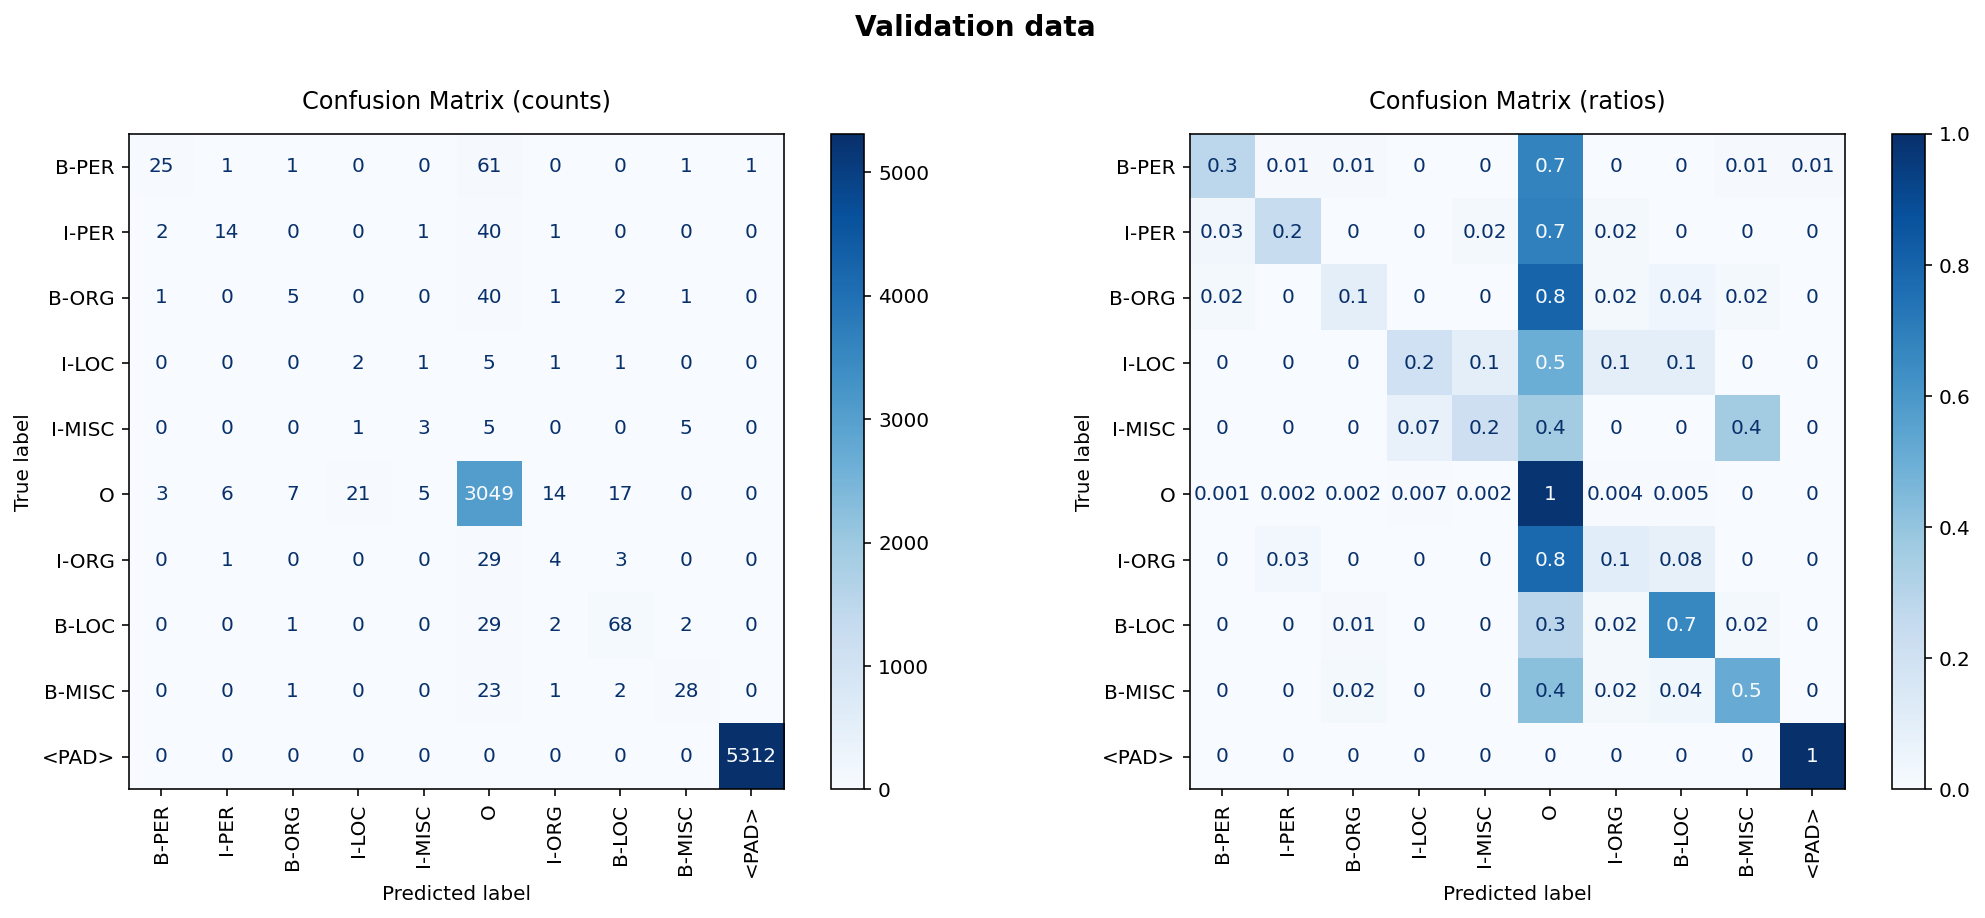

In [60]:
# Validation data

display_labels = list(tag2index.keys()) + ['<PAD>']
plot_confusion_matrix(y_val.flatten(),y_val_pred.flatten(),display_labels,'Validation data')

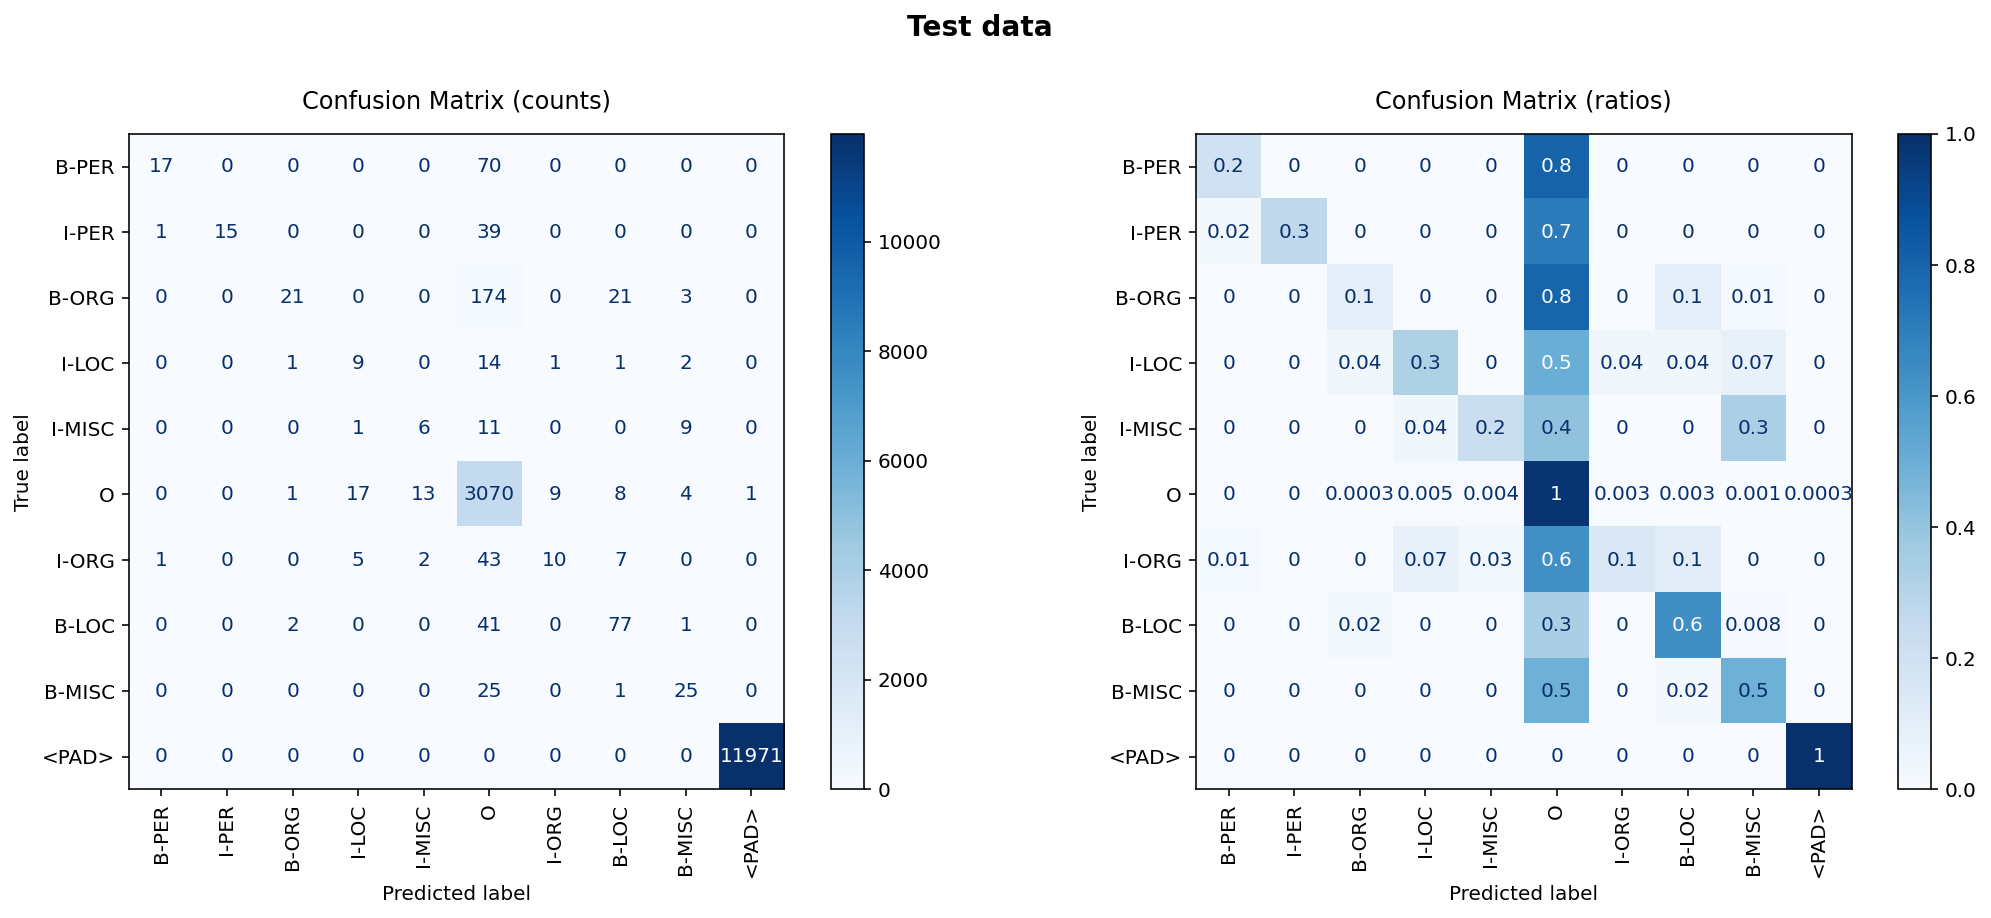

In [61]:
# Test data

display_labels = list(tag2index.keys()) + ['<PAD>']
plot_confusion_matrix(y_te.flatten(),y_te_pred.flatten(),display_labels,'Test data')

### Performance over full named-entity

([Source](https://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/))

When we train a NER system, the most common evaluation method is to measure precision, recall and f1-score at a token level. These metrics are indeed useful to tune a NER system. But when using the predicted named-entities for downstream tasks, it is more useful to evaluate with metrics at a full named-entity level. 

This evaluation metrics used below go beyond a simple token/tag based schema, and consider different scenarios based on whether all the tokens that belong to a named entity were classified or not, and also whether the correct entity type was assigned.



In [62]:
# Load modules
# Source : https://github.com/davidsbatista/NER-Evaluation

from ner_evaluation.ner_eval import collect_named_entities
from ner_evaluation.ner_eval import compute_metrics
from ner_evaluation.ner_eval import compute_precision_recall_wrapper
from copy import deepcopy

In [63]:
# Show tag2index index
tag2index

{'B-PER': 0,
 'I-PER': 1,
 'B-ORG': 2,
 'I-LOC': 3,
 'I-MISC': 4,
 'O': 5,
 'I-ORG': 6,
 'B-LOC': 7,
 'B-MISC': 8}

In [64]:
# Invert tag2index dict

index2tag = {v: k for k, v in tag2index.items()}

# Add (key,value) pair for <PAD> token
index2tag[9] = '<PAD>'

# Show index2tag dict
index2tag

{0: 'B-PER',
 1: 'I-PER',
 2: 'B-ORG',
 3: 'I-LOC',
 4: 'I-MISC',
 5: 'O',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'B-MISC',
 9: '<PAD>'}

In [65]:
# True labels for test set
y_te  

array([[2, 5, 5, ..., 9, 9, 9],
       [7, 5, 9, ..., 9, 9, 9],
       [5, 5, 5, ..., 9, 9, 9],
       ...,
       [5, 5, 5, ..., 9, 9, 9],
       [5, 8, 5, ..., 9, 9, 9],
       [5, 5, 5, ..., 9, 9, 9]])

In [66]:
# Predicted labels for test set

y_te_pred  

array([[5, 5, 5, ..., 9, 9, 9],
       [7, 3, 9, ..., 9, 9, 9],
       [5, 5, 5, ..., 9, 9, 9],
       ...,
       [5, 5, 5, ..., 9, 9, 9],
       [5, 8, 5, ..., 9, 9, 9],
       [5, 5, 5, ..., 9, 9, 9]])

Below, I will convert the labels (integers) to tags, as this is the expected input format from the `ner_evaluation.ner_eval` module.

In [67]:
# Create lists of true and predicted labels for test data (format: tags)

test_sents_labels = []  # True labels (format: tags)
y_pred            = []  # Predicted labels (format: tags)

for sentence_true, sentence_pred in zip(y_te, y_te_pred):
    
    # True labels
    test_sents_labels.append([index2tag[tok] for tok in sentence_true if tok !=9]) # Do not append <PAD> tokens
    
    seq_len = len([index2tag[tok] for tok in sentence_true if tok !=9])  # Get sequence length
    
    # Predicted labels
    y_pred.append([index2tag[tok] for tok in sentence_pred][0:seq_len])  # Do not append predictions for <PAD> tokens

In [68]:
# Show an example of true/predicted labels

index = 1
print('True labels:\t\t',test_sents_labels[index])
print('Predicted labels:\t',y_pred[index])

True labels:		 ['B-LOC', 'O']
Predicted labels:	 ['B-LOC', 'I-LOC']


In [69]:
# Collect named entities for true/predicted labels
index = 1
true = collect_named_entities(test_sents_labels[index])
pred = collect_named_entities(y_pred[index])

print('Named entities in true labels:\n\n',true)
print('\nNamed entities in predicted labels:\n\n',pred)

Named entities in true labels:

 [Entity(e_type='LOC', start_offset=0, end_offset=0)]

Named entities in predicted labels:

 [Entity(e_type='LOC', start_offset=0, end_offset=1)]


In [70]:
# Show metrics for 1 sample
pd.DataFrame(compute_metrics(true, pred, ['LOC', 'MISC', 'PER', 'ORG'])[0])

,strict,ent_type,partial,exact
correct,0,0,0,0
incorrect,0,0,0,0
partial,0,0,0,0
missed,1,1,1,1
spurious,1,1,1,1
precision,0,0,0,0
recall,0,0,0,0
actual,1,1,1,1
possible,1,1,1,1


In [71]:
from ner_evaluation.ner_eval import Evaluator
evaluator = Evaluator(test_sents_labels, y_pred, ['LOC', 'MISC', 'PER', 'ORG'])

In [72]:
results, results_agg = evaluator.evaluate()

2022-02-20 19:35:59 root INFO: Imported 315 predictions for 315 true examples


In [73]:
pd.DataFrame(results)

,ent_type,partial,strict,exact
correct,113.000000,130.000000,112.000000,130.000000
incorrect,20.000000,0.000000,21.000000,3.000000
partial,0.000000,3.000000,0.000000,0.000000
missed,345.000000,345.000000,345.000000,345.000000
spurious,92.000000,92.000000,92.000000,92.000000
possible,478.000000,478.000000,478.000000,478.000000
actual,225.000000,225.000000,225.000000,225.000000
precision,0.502222,0.584444,0.497778,0.577778
recall,0.236402,0.275105,0.234310,0.271967


# The end!